# Model selection and assessment, cross validation

## Importing the libraries and data
Import the `numpy`, `matplotlib` and `scikit-learn` libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, ShuffleSplit
from sklearn import metrics

Import the breast cancer dataset. The [breast cancer diagnostic dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) is a classic and a easy binary classification dataset. It contains 569 samples (212 malignant cells, 357 benign cells) and 30 features. Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe
characteristics of the cell nuclei present in the image (mean radius, mean symmetry, etc.).

In [2]:
# TO BE COMPLETED

dataset = datasets.load_breast_cancer()
X, y = dataset.data, dataset.target
target_names = dataset.target_names

## Data exploration through PCA
We perform a [Principal Component Analysis](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (PCA) for data exploration purposes. In order to obtain meaningful results, for each feature we remove the mean and scale to unit variance.

In [3]:
# TO BE COMPLETED

# for each feature remove the mean and scale to unit variance
X_scaled = StandardScaler().fit_transform(X)

# build a PCA instance  
pca = PCA()

# PCA transform 
X_pca = pca.fit_transform(X_scaled)

Make the plot:

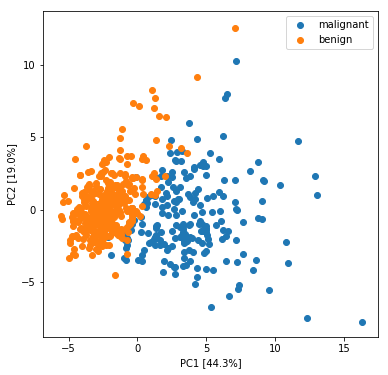

In [4]:
# plot the first two principal components
plt.figure(figsize=(6, 6))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], label=target_names[0])
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], label=target_names[1])
plt.xlabel("PC1 [{:.1f}%]".format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel("PC2 [{:.1f}%]".format(100 * pca.explained_variance_ratio_[1]))
plt.legend()
plt.show()

# Model selection and assessment
Now we prepare a complete pipeline for model selection and assessment using the [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). We tune the classifier by an inner cross validation where we search the optimal number of trees to use in the forest (the `n_estimators` parameter).

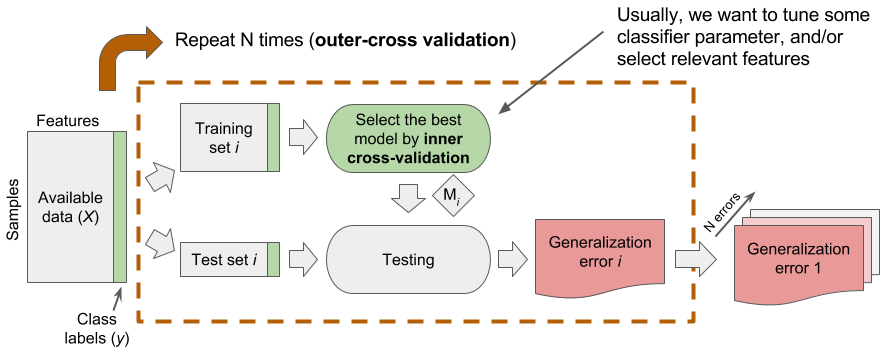

Initialize the classifier and the grid of parameters to be tuned:

In [5]:
# TO BE COMPLETED

clf = RandomForestClassifier(random_state=0) # random_state=0 set the random seed to 0 and ensures replicability
param_grid = {'n_estimators': [1, 2, 5, 10, 20, 50]}

Now we define the inner and the outer cross validation (CV). We choose:
* a [random subsampling CV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html) with 10 repeats and 1/4 samples in the test set for the outer CV (model assessment);
* a [k-fold CV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) with 4 splits for the inner CV (model selection).

In [6]:
# TO BE COMPLETED

outer_cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
inner_cv = KFold(n_splits=4, random_state=0, shuffle=True)

Set up the model selection module using the [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) class. The `GridSearchCV` makes and exhaustive search over the specified parameter values through cross validation (the `inner_cv` in this case). In this case the best parameter setting is chosen maximizing the CV average accuracy. `GridSearchCV` is itself an estimator: it implements the `fit()` and the `predict()` methods.

In [7]:
# TO BE COMPLETED

model_sel_clf = GridSearchCV(estimator=clf, param_grid=param_grid, 
                             cv=inner_cv)

Now we create the model assessment loop using the [cross_val_score()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function. It takes an estimator (in this case `model_sel_clf`), the data and the cross validation setup (`outer_cv`) and returns the test (generalization) accuracy for each iteration:

In [8]:
# TO BE COMPLETED

test_acc = cross_val_score(model_sel_clf, X=X, y=y, cv=outer_cv)
test_acc

array([ 0.95104895,  0.94405594,  0.93706294,  0.95804196,  0.96503497,
        0.93006993,  0.97202797,  0.94405594,  0.93706294,  0.94405594])

We can compare the test accuracy of the random forest classifier with a baseline. For this purpose we compute the test accuracy of a simple ["most frequent" classifier](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) which each time predicts with the most frequent class in the training set:

In [9]:
# TO BE COMPLETED

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_test_acc = cross_val_score(dummy_clf, X=X, y=y, cv=outer_cv)
dummy_test_acc

array([ 0.62937063,  0.6013986 ,  0.6013986 ,  0.62937063,  0.58741259,
        0.66433566,  0.65734266,  0.57342657,  0.68531469,  0.59440559])

## Plot the test (generalization) error

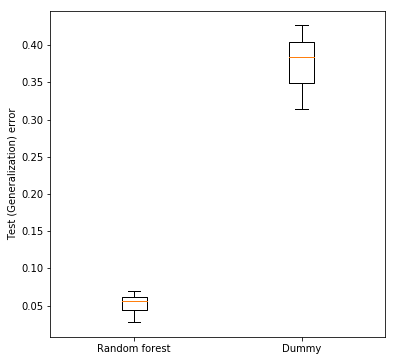

In [10]:
plt.figure(figsize=(6, 6))
plt.boxplot([1-test_acc, 1-dummy_test_acc], labels=["Random forest", "Dummy"])
plt.ylabel("Test (Generalization) error")
plt.show()

## Build the final model

Given a honest estimate of the generalization error, we can compute the final model using all the data available. In order to do this we search the best model using the `GridSearchCV` defined above.

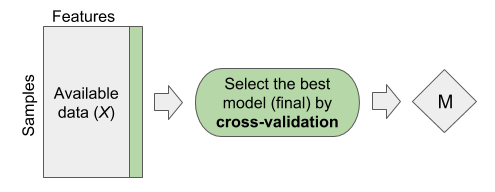



In [11]:
# TO BE COMPLETED

model_sel_clf.fit(X, y)

# extract the best model
final_clf = model_sel_clf.best_estimator_
print(final_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)


Now we can predict new samples with `final_clf.predict()`.